<a href="https://colab.research.google.com/github/Jiayi-Shi/brain-to-text/blob/main/dl4nlp_ass01_JiayiShi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for NLP - Exercise 01
Building, Tuning and Evaluating a standard RNN Model

General hints:
* Have a look at the imports below when solving the tasks
* Use the given modules and all submodules of the imports, but don't import anything else!
    * For instance, you can use other functions under the `torch` or `nn` namespace, but don't import e.g. PyTorch Lightning, etc.
* It is recommended to install all packages from the provided environment file
* Feel free to test your code between sub-tasks of the exercise sheet, so that you can spot mistakes early (wrong shapes, impossible numbers, NaNs, ...)
* Just keep in mind that your final submission should be compliant to the provided initial format of this file

Submission guidelines:
* Make sure that the code runs on package versions from the the provided environment file
* Do not add or change any imports (also don't change the naming of imports, e.g. `torch.nn.functional as f`)
* Remove your personal, additional code testings and experiments throughout the notebook
* Do not change the class, function or naming structure as we will run tests on the given names
* Additionally export this notebook as a `.py` file, and submit **both** the executed `.ipynb` notebook with plots in it **and** the `.py` file
* **Deviation from the above guidelines will result in partial or full loss of points**

If you are using Google Colab or similar services, make sure to install all necessary packages so that the import cell below is working.

Usually, you would need to `!pip install`:
```
!pip install datasets==2.15
!pip install spacy==3.6.1
!pip install torch==2.8.0    # just to be sure we are all working with the same version
!pip install torchtext==0.16.2
!python -m spacy download en_core_web_sm
```

Make sure to comment out the lines before submitting!

In [ ]:
# I am unable to successfully install and use torch==2.8.0 on Colab, either the official version or the nightly version, because it has not been released yet.
# torch==2.8.0 conflicts with torchtext==0.16.2, replaced with torch==2.2.0
# spacy==3.6.1 fails on Python 3.12 in Google Colab, replaced with 3.8.7 (API compatible)


!pip install -U datasets==2.15
!pip install -U spacy==3.8.7
!pip install -U torch==2.2.0
!pip install -U torchtext==0.16.2
!pip install -U huggingface-hub==0.36.0
!pip install -U scikit-learn==1.7.2
!pip install -U matplotlib==3.10.7
!python -m spacy download en_core_web_sm

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Fou


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/usr/local/lib/python3.12/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.12/dist-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.12/dist-packages/spacy/compat.py", line 4, in <module>
    from thinc.

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

In [ ]:
# Please allow me to check the version, thank you!
import torch, torchtext, spacy, datasets, huggingface_hub, sklearn, matplotlib

print("datasets:", datasets.__version__)
print("spacy:", spacy.__version__)
print("torch:", torch.__version__)
print("torchtext:", torchtext.__version__)
print("huggingface_hub:", huggingface_hub.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

datasets: 2.15.0
spacy: 3.8.7
torch: 2.2.0+cu121
torchtext: 0.16.2+cpu
huggingface_hub: 0.36.0
scikit-learn: 1.7.2
matplotlib: 3.10.7


In [ ]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [ ]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

## Task 1 - Download and prepare the dataset
- Load the train and test set of IMDB (it is included in the `datasets` module we imported above)
- Split the train set into train and validation set
    * Train set should consist of the middle 10% to 85% of data
    * Validation set should be the two remaining ends
    * You can achieve this slicing directly within the `load_dataset` function, check out the [Huggingface slicing API](https://huggingface.co/docs/datasets/v2.13.1/loading#slice-splits)
- Test set should stay unchanged

In [ ]:
from datasets import load_dataset

train_data = load_dataset("imdb", split="train[10%:85%]")      # middle 10%-85%
dev_data   = load_dataset("imdb", split="train[:10%]+train[85%:]")  # two ends
test_data  = load_dataset("imdb", split="test") # unchanged

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

* Define the tokenizer using `get_tokenizer` with spacy's `en_core_web_sm` module
    * You don't have to import spacy for that, but it is necessary to have spacy installed and the `en_core_web_sm` module downloaded
* Create the vocabulary using `build_vocab_from_iterator`
    * Think about which split(s) should be used to build the vocabulary
    * Include two special tokens: `'<UNK>'` at index `0`, `'<PAD>'` at index `1`
    * Limit the vocab size to `VOCAB_SIZE`, as defined in the beginning
    * Set the vocab's default returning index to `0` by making the `'<UNK>'` token default
    
Hint:
* This might be a good moment to add a personal test to check whether your vocab actually returns `0` for an unknown input token

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

def yield_tokens(data_iter):
    for item in data_iter:
        yield tokenizer(item["text"])

vocab = build_vocab_from_iterator(
    yield_tokens(train_data),
    specials=["<UNK>", "<PAD>"],
    max_tokens=VOCAB_SIZE
)

# set default index for unknown tokens
vocab.set_default_index(vocab["<UNK>"])

* Use the tokenizer and vocabulary to turn your three data splits into indices
* Limit the maximum tokenized sequence length to `MAX_LEN`

**Note**:
In practice, performing this step on its own during the preprocessing stage is usually not feasible due to the memory constraints associated with storing large datasets. Consequently, the tokenization and indexing steps are typically performed "on the fly" within the `DataLoader`, specifically in the `collate_batch` step.

In [ ]:
def text_to_indices(example):
    tokens = tokenizer(example["text"])
    indices = vocab(tokens)[:MAX_LEN]
    return {"input_ids": indices}

# apply to all splits
train_idx = train_data.map(text_to_indices)
dev_idx   = dev_data.map(text_to_indices)
test_idx  = test_data.map(text_to_indices)

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

* Define a torch dataset by inhereting from `Dataset`
* It should create the building block to return the tokenized indices and labels for a given index
* Instantiate it

In [ ]:
import torch
from torch.utils.data import Dataset

class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl

    def __getitem__(self, idx):
        return torch.tensor(self.seq[idx]["input_ids"]), torch.tensor(self.lbl[idx])

    def __len__(self):
        return len(self.seq)


In [ ]:
train_set = ImdbDataset(train_idx["input_ids"], train_idx["label"])
dev_set   = ImdbDataset(dev_idx["input_ids"], dev_idx["label"])
test_set  = ImdbDataset(test_idx["input_ids"], test_idx["label"])

* Having batches in which samples have a similar length, and thus less padding variations, improves training results
* A `GroupedSampler` allows us to create a sampler with which we can customize the data loading process
* It can then be implemented into the `DataLoader`, which automates loading data in multiple processes
* Write a sampler which allows us to group together samples of similar length into a batch
    * The `GroupedSampler` takes as input the tokenized sequences from `ImdbDataset`, as well as the batch size
    * First, in the `__init__` method, pair each sequence index with its tokenized sequence length
        * The result should be a list of tuples: `[(index, tokenized_sequence_length), ...]`
    * In the `__iter__` method, we now:
        * Shuffle the list
        * generate groups of size `BATCH_SIZE * 100`
        * Each group of size `BATCH_SIZE * 100` should be sorted in itself by the sequence length we calculated above
            * Sorting within each group is important because sorting based on the whole dataset would eliminate all training input variations
            * By shuffling in the `__iter__` method, we shuffle the set of indices in each new iteration (which equals an epoch), therefore, we keep input variation
        * The result should be a list of tuples sorted by ascending sequence length: `[(index, tokenized_sequence_length), ...]`
        * After each `BATCH_SIZE * 100` number of tuples, the sequence length of samples should drop and increase again
        * Example:
            ```
            Sample index 3199: (1234, 256)
            Sample index 3200: (567, 32)
            Sample index 3201: (890, 33)
            ```
        * Filter the created and sorted list to only consist of indices. Make sure to keep the sorting!
        * Return this list as an iterator
    * Complete the `__len__` method

In [ ]:
from torch.utils.data import Sampler
import random

class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        self.batch_size = batch_size
        self.lengths = [(i, len(seqs[i])) for i in range(len(seqs))]

    def __iter__(self):
        # shuffle entire list
        random.shuffle(self.lengths)
        # group into chunks
        chunk_size = self.batch_size * 100
        chunks = [self.lengths[i:i+chunk_size] for i in range(0, len(self.lengths), chunk_size)]
        # sort each chunk by sequence length
        sorted_chunks = [sorted(chunk, key=lambda x: x[1]) for chunk in chunks]
        # flatten and keep only indices
        indices = [idx for chunk in sorted_chunks for idx, _ in chunk]
        return iter(indices)

    def __len__(self):
        return len(self.lengths)

* Now create the `GroupedSampler`, use it as input to create a `BatchSampler` (imported in the beginning)

In [ ]:
from torch.utils.data import BatchSampler

train_grouped_sampler = GroupedSampler(train_idx["input_ids"], BATCH_SIZE)
train_sampler = BatchSampler(train_grouped_sampler, batch_size=BATCH_SIZE, drop_last=False)

* Define a collate function which takes in a `batch` of tokenized sequences and labels created by the `BatchSampler`
    * Make sure to understand the structure of an input `batch`. Test around a bit to see what exactly they return.
* The collate function then:
    * pads these indices to the same length
        * use `padding_value=1`, `0` should be reserved for `UNK` token
    * turns the labels into tensors
    * finally, it creates a tensor which stores the length of all tokenized sentences **before** padding
    * the function should return 3 batched tensors: sequences, labels, lengths

In [ ]:
import torch
from torch.utils.data import Dataset

class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl

    def __getitem__(self, idx):
        return torch.tensor(self.seq[idx]), torch.tensor(self.lbl[idx])

    def __len__(self):
        return len(self.seq)

# re-instantiate datasets
train_set = ImdbDataset(train_idx["input_ids"], train_idx["label"])
dev_set   = ImdbDataset(dev_idx["input_ids"], dev_idx["label"])
test_set  = ImdbDataset(test_idx["input_ids"], test_idx["label"])

* Now create the final `DataLoader` for the train set
    * For your training, set the number of workers to your liking/cpu cores setup
    * When submitting this exercise, please set `num_workers=2` at maximum
* Repeat the `DataLoader` creation process for the validation and test set
    * It is not necessary to introduce randomness into the validation and test set
    * Create an `ImdbDataset` and `DataLoader` instance
    * leave `shuffle` off and don't include any Samplers
    * still include the correct batch size and collate function

In [ ]:
from torch.utils.data import DataLoader

# collate function: pad sequences, keep lengths on CPU
def collate_batch(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    padded  = torch.nn.utils.rnn.pad_sequence(
        seqs, batch_first=True, padding_value=1
    )
    labels  = torch.tensor(labels, dtype=torch.float32)
    return padded, labels, lengths

# create dataloaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    collate_fn=collate_batch,
    num_workers=2
)

dev_loader = DataLoader(
    dev_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    shuffle=False,
    num_workers=2
)


## Task 2 - Build Your Model
The model should consist of:
- an **embedding layer**, which takes `vocab_size` and `embedding_dim` as parameters
- a **dropout layer**, which takes `dropout` as a parameter
- an **LSTM layer**, which takes `embedding_dim` and `rnn_size` as parameters, and is bidirectional
- a **linear layer**, which takes the dimension of rnn output as input dimension and returns an output of `hidden_size` dimensions
- a **linear layer**, which first takes the previous layers output as input and returns one prediction per class of the dataset
- the output of the BiLSTM has hidden representation tensors for each index of each sequence. However, for the task of sequence classification, we just need one hidden representation tensor per sequence. Use `torch.mean()` as a pooling function for dimensionality reduction.
- use **dropout** on the embeddings and appropriate linear layer
- use **ReLU** as the activation function on the appropriate linear layer

_Hints:_
  - keep the position of the batch dimension equal across all layers
  - _use `pack_padded_sequence`_ and `pad_packed_sequence` at the appropriate steps. For more information, check out [this answer on stackoverflow](https://stackoverflow.com/a/56211056)
  - remember to include the `padding_idx=1` at relevant positions
  - as this is a binary classification task, it is possible to have 1 or 2 output neurons. Use your preference, but adjust the loss function towards your choice

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.dropout_emb = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            embedding_dim, rnn_size, batch_first=True, bidirectional=True
        )
        self.linear1 = nn.Linear(rnn_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, seq, lengths):
        # seq: [batch, seq_len], lengths: [batch]
        emb = self.dropout_emb(self.embedding(seq))
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        mean_out = out.mean(dim=1) # mean pooling
        hidden = self.dropout_fc(self.relu(self.linear1(mean_out)))
        logits = self.linear2(hidden)
        return logits.squeeze(1)  # [batch]


## Task 3 - Inner train loop
* Create a global `device` variable which checks whether a GPU is available or not, and sets the device to either GPU or CPU.

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* Write the inner train/test loop by completing the function `process`.
    * It takes the model, a dataloader, criterion and optionally the optimizer
    * The function iterates once through the dataloader, i.e. one epoch
    * Include the `tqdm` functionality for the loop through the dataloader by placing the loader inside `tqdm()`
        * Print its output to `file=sys.stdout`, and use `'batches'` as unit
        * You can also add a `desc='...'` to get a marking whether we currently train or evaluate
    * The function also moves the sequences and labels to `device`
    * The `lengths` need to stay on CPU!
    * If the optimizer is given, training with backpropagation is performed, then the below defined metrics are returned
    * If the optimizer is missing, evaluation is performed and the below described metrics are calculated
    * Values to be calculated:
        * Loss, Accuracy, both as averages of the total number of samples per epoch
        * F1 score between all predictions and labels of the epoch

In [ ]:
import torch
from tqdm import tqdm
import sys
from sklearn.metrics import f1_score

def process(model, loader, criterion, optim=None):
    is_train = optim is not None
    model.train() if is_train else model.eval()

    total_loss, total_correct, total_samples = 0, 0, 0
    preds_all, labels_all = [], []

    for seqs, labels, lengths in tqdm(loader, file=sys.stdout, unit='batches'):
        seqs, labels = seqs.to(device), labels.to(device)
        optim.zero_grad() if is_train else None

        with torch.set_grad_enabled(is_train):
            logits = model(seqs, lengths)
            loss = criterion(logits, labels.float())
            preds = (torch.sigmoid(logits) > 0.5).long()

            if is_train:
                loss.backward()
                optim.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        preds_all.extend(preds.cpu().tolist())
        labels_all.extend(labels.cpu().tolist())

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    f1 = f1_score(labels_all, preds_all)

    return avg_loss, avg_acc, f1


# Task 4 - Training and Hyperparameter Optimization
In the following, we provide 3 configurations for the above created BiLSTM. Try to understand how they differ from each other.

In [ ]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5
    }

}

* Choose the correct criterion to train and evaluate your created model

In [ ]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

Use the given functions `regularized_f1` and `save_metrics` from the start of the notebook to implement the hyperparameter search and training runs.

Specifically:
* Iterate through each configuration
* Create and re-create the model for each new configuration run
    * Move the model to the `device`
* Create and re-create the optimizer with each new configuration model's paramaters
    * Use Adam as the optimizer
    * Use the learning rate defined at the beginning of notebook
* Train each configuration for `NUM_EPOCHS` epochs
* Change the model into train and evaluation mode at appropriate times
* Stop gradient calculation for evaluation runs
* Save metrics after each train and evaluation runs.
    * Have a look at the function to see what the expected inputs are
    * In the `.csv` file, only numbers should be entered
    * For instance, the inputs for the columns `config` and `epoch` should be e.g. `1`, _not_ `config1` or `epoch1`
* Optional: Print training progress for your own information

In order to check whether our model generalizes or just 'remembers', we need to compare the model's performance on the train set to the performance on the validation set. As we are only interested in non-overfitting performances, we only want to save model checkpoints when the model actually generalizes, i.e. has a higher F1 score on the validation set than on the train set.
* Calculate the regularized f1 score using the given function
* Keep track of multiple values during training:
    * Save the overall (i.e. across all configs *and* epochs) highest validation F1 score
        * Save your best model parameters
        * Overwrite your model parameters every time your model fulfills both the `regularized_f1` criteria and is better than the previous overall highest F1 score
        * In the end, the last saved `best_model.pt` parameters are automatically the best
        * Hint: Keep track (e.g. by printing or in a variable), which config produced the best model, so you can directly load that config for the test set run.
    * Track the highest F1 score inside a configuration but across epochs
        * Implement early-stopping for a configuration run if 3 consecutive epochs are below the highest F1 score for the current configuration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

path = './'
logging_file = 'results.csv'
NUM_EPOCHS = 3
LEARNING_RATE = 1e-3

best_overall_f1 = 0.0
best_model_state = None
best_config = None

for i, (cfg_name, cfg) in enumerate(configs.items(), start=1):
    model = BiLSTM(**cfg).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    best_dev_f1 = 0.0
    no_improve_epochs = 0

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc, train_f1 = process(model, train_loader, criterion, optimizer)
        dev_loss, dev_acc, dev_f1 = process(model, dev_loader, criterion)

        # keyword-only parameters path and fname
        save_metrics(
            i, epoch,
            train_loss, train_acc, train_f1,
            dev_loss, dev_acc, dev_f1,
            path=path, fname=logging_file
        )

        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= 3:
                break

        reg_f1 = regularized_f1(train_f1, dev_f1)
        if reg_f1 and dev_f1 > best_overall_f1:
            best_overall_f1 = dev_f1
            best_model_state = model.state_dict()
            best_config = cfg_name
            torch.save(best_model_state, "best_model.pt")

print(f"Best config: {best_config} | Highest Dev F1: {best_overall_f1:.4f}")


100%|██████████| 196/196 [00:02<00:00, 83.62batches/s]
Best config: config3 | Highest Dev F1: 0.8255


* Load in the created `results.csv` file
* Create 6 plots: 3 rows with each 2 sub-plots
* Each row of plots should correspond to a configuration
* Each left plot shows the loss progression per epoch
    * Include both train and evaluation progress in the same plot, but plot the evaluation lines dashed
    * Plot losses in blue
* Each right plot shows both the accuracy and F1 progression per epoch
    * Include both train and evaluation progess in the same plot, but plot the evaluation lines dashed
    * Plot accuracy in orange, and plot F1 in green
* Have a look at the example plot file included with this exercise. It constitutes one row of the plot.
* After plotting, briefly describe what problems and successes you see with each configuration

**Here you can see a partial example plot**
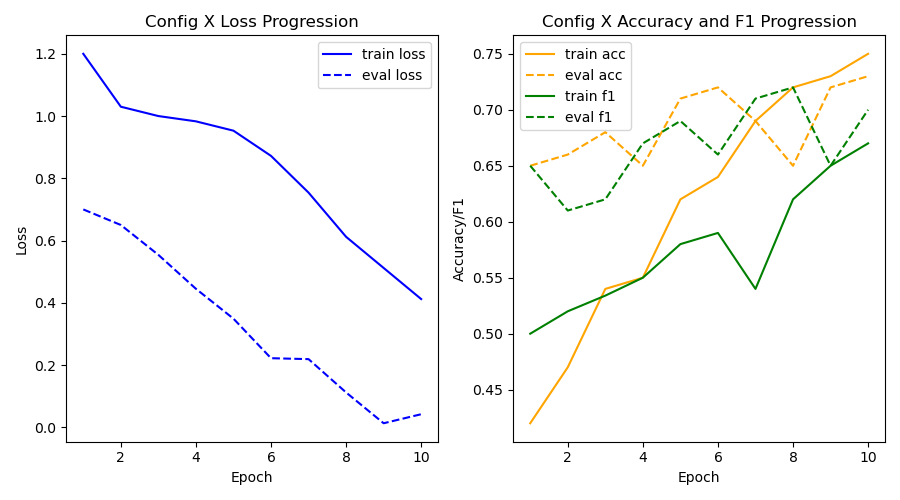


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results.csv')

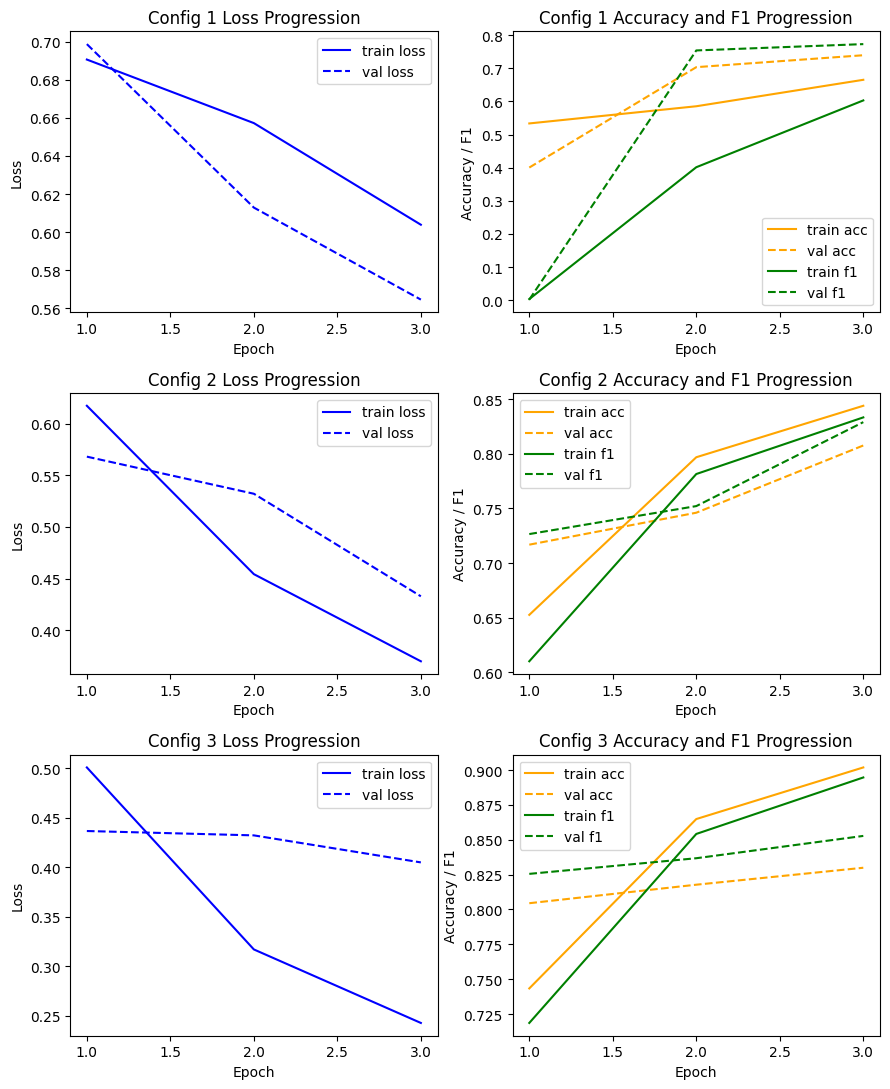

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(9, 11))

for i, cfg_id in enumerate(sorted(df['config'].unique())):
    sub = df[df['config'] == cfg_id].copy()
    sub = sub.drop_duplicates(subset='epoch', keep='last').sort_values('epoch')

    # Loss
    ax[i, 0].plot(sub['epoch'], sub['train_loss'], color='blue', label='train loss')
    if 'eval_loss' in sub.columns:
        ax[i, 0].plot(sub['epoch'], sub['eval_loss'], color='blue', ls='--', label='eval loss')
    elif 'dev_loss' in sub.columns:
        ax[i, 0].plot(sub['epoch'], sub['dev_loss'], color='blue', ls='--', label='dev loss')
    elif 'val_loss' in sub.columns:
        ax[i, 0].plot(sub['epoch'], sub['val_loss'], color='blue', ls='--', label='val loss')
    ax[i, 0].set_title(f'Config {cfg_id} Loss Progression')
    ax[i, 0].set_xlabel('Epoch'); ax[i, 0].set_ylabel('Loss'); ax[i, 0].legend()

    # Accuracy & F1
    ax[i, 1].plot(sub['epoch'], sub['train_acc'], color='orange', label='train acc')
    if 'eval_acc' in sub.columns:
        ax[i, 1].plot(sub['epoch'], sub['eval_acc'], color='orange', ls='--', label='eval acc')
    elif 'dev_acc' in sub.columns:
        ax[i, 1].plot(sub['epoch'], sub['dev_acc'], color='orange', ls='--', label='dev acc')
    elif 'val_acc' in sub.columns:
        ax[i, 1].plot(sub['epoch'], sub['val_acc'], color='orange', ls='--', label='val acc')

    ax[i, 1].plot(sub['epoch'], sub['train_f1'], color='green', label='train f1')
    if 'eval_f1' in sub.columns:
        ax[i, 1].plot(sub['epoch'], sub['eval_f1'], color='green', ls='--', label='eval f1')
    elif 'dev_f1' in sub.columns:
        ax[i, 1].plot(sub['epoch'], sub['dev_f1'], color='green', ls='--', label='dev f1')
    elif 'val_f1' in sub.columns:
        ax[i, 1].plot(sub['epoch'], sub['val_f1'], color='green', ls='--', label='val f1')

    ax[i, 1].set_title(f'Config {cfg_id} Accuracy and F1 Progression')
    ax[i, 1].set_xlabel('Epoch'); ax[i, 1].set_ylabel('Accuracy / F1'); ax[i, 1].legend()

plt.tight_layout()
plt.show()

___

Student answer here:
___

* As the final step, instantiate a model with the config of the best run
* Load the `state_dict`
* Evaluate it on the test set
    * Don't forget to actviate evaluation mode and deactivate gradient calculation
* Comment on the performance
    * Did it generalize well? Why? Why not?
    * What could be done to improve the performance even further?
        * Consider also the hyperparameters from the third cell and discuss potential tradeoffs.

In [ ]:
import torch

# re-instantiate model with best config and load weights
model = BiLSTM(**configs[best_config]).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))

# evaluate on test set
model.eval()
with torch.no_grad():
    test_loss, test_acc, test_f1 = process(model, test_loader, criterion)


100%|██████████| 782/782 [00:09<00:00, 80.64batches/s]


___

Student answer here:
___

In [ ]:
Config 3 achieved the highest validation F1 (0.83), showing good generalization and stable loss reduction. Its accuracy and F1 curves indicate strong learning without overfitting. Using pretrained embeddings or more epochs could further enhance performance.